In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from scipy import optimize
from scipy.fft import fft, fftshift
import wavesim_functions as wave

In [2]:
depth = 100.
hs = 35.
# tp = 12. 

In [3]:
alpha = 0.7
om_p = 0.8
gamma = 3.3  # make larger to decrease width of Jonswap
r = 5.
phi_m = np.pi
beta = 4.
nu = 2.7
sig_l = 0.55  # make smaller to decrease directional spreading
sig_r = 0.26  # make zero to decrease directional spreading


In [4]:
om_num = 50
om_range = np.linspace(start=1e-3, stop=3, num=om_num)
f_range = om_range / 2*np.pi

phi_num = 100
phi_range = np.linspace(start=0, stop=2 * np.pi, num=phi_num)

x_num = 100
x_range = np.linspace(start=-50, stop=50, num=x_num)

y_num = 100
y_range = np.linspace(start=-50, stop=50, num=y_num)

d_om = om_range[1] - om_range[0]
d_phi = phi_range[1] - phi_range[0]


In [5]:
D_sprd = np.empty((phi_num, om_num))
for i_o, om in enumerate(om_range):
    for i_p, phi in enumerate(phi_range):
        D_sprd[i_p, i_o] = wave.sprd_fnc(om, phi, om_p, phi_m, beta, nu, sig_l, sig_r)

In [6]:
jnswp_dns = np.empty(om_num)
for i_o, om in enumerate(om_range):
    jnswp_dns[i_o] = wave.alt_djonswap(om, alpha, om_p, gamma, r)

jnswp_area = sum(d_om * jnswp_dns)
jnswp_dns *= hs ** 2 / (16 * jnswp_area)  # rescale to provide given hs
jnswp_area = sum(d_om * jnswp_dns)
jnswp_area

76.56250000000001

In [7]:
Dr_spctrm = np.empty((phi_num, om_num))
for i_o, om in enumerate(om_range):
    for i_p, phi in enumerate(phi_range):
        Dr_spctrm[i_p, i_o] = wave.frq_dr_spctrm(om, phi, alpha, om_p, gamma, r, phi_m, beta, nu, sig_l, sig_r)

In [8]:
spctrm_vol = sum(sum(d_om * d_phi * Dr_spctrm))
Dr_spctrm *= hs ** 2 / (16 * spctrm_vol)  # rescale to provide given hs
spctrm_vol = sum(sum(d_om * d_phi * Dr_spctrm))
spctrm_vol

76.56249999999999

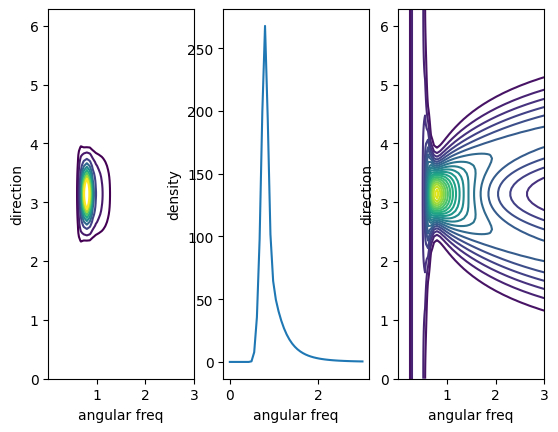

In [9]:
omega_grid, phi_grid = np.meshgrid(om_range, phi_range)
plt.figure()

plt.subplot(1, 3, 1)
plt.contour(omega_grid, phi_grid, Dr_spctrm, levels=[15, 30, 60, 90, 120, 150, 180, 210, 240])
plt.xlabel("angular freq")
plt.ylabel("direction")

plt.subplot(1, 3, 2)
plt.plot(om_range, jnswp_dns)
plt.xlabel("angular freq")
plt.ylabel("density")

plt.subplot(1, 3, 3)
plt.contour(omega_grid, phi_grid, D_sprd, levels=20)
plt.xlabel("angular freq")
plt.ylabel("direction")

plt.show()

In [10]:
nt = 100
trange = np.linspace(0, 15, nt)
names = []
x_grid, y_grid = np.meshgrid(x_range, y_range)  # expand x and y axis onto a grid to plot eta over

In [11]:
for it, t in enumerate(trange):

    eta = wave.spatial_random_wave(om_range=om_range, phi_range=phi_range, Dr_spctrm=Dr_spctrm, t=t, x_range=x_range, y_range=y_range, h=depth)

    print(np.var(eta))

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    surf = ax.plot_surface(x_grid, y_grid, eta)

    ax.set_zlim(-40, 40)

    name = f'time_{it}.png'
    names.append(name)

    plt.savefig(name)
    plt.close()


70.32712439694718
69.46283165000575
68.7382830670447
68.22283839338925
67.96146534534144
67.96607113144378
68.21940802782719
68.68782316466593
69.33494950899856
70.12894583134408
71.04056399726699
72.03520153719388
73.06563659041997
74.07135114304586
74.98595076899065
75.74907384290219
76.31653343009557
76.66374155753593
76.78168089305402
76.66901822134618
76.32571609428544
75.75181803285648
74.95132862832679
73.9378608883002
72.73800525297871
71.39037774430398
69.94140009429047
68.44083846830544
66.93972615158718
65.49101492103696
64.15091788758593
62.97815579538757
62.029668811041375
61.35375573817054
60.98331410659631
60.93172978518244
61.19223257727475
61.739553424302066
62.53192356914849
63.512298465755805
64.60935619021427
65.73990572966365
66.8139425768342
67.74199383696511
68.4428401943367
68.84940898582217
68.91185177265143
68.59862124356755
67.89733926008716
66.81660691737879
65.38811545361648
63.66689510938013
61.72760707690779
59.65662801548038
57.54212765554365
55.46565986

In [12]:
with imageio.get_writer('random-waves-moving.gif', mode='I') as writer:
    for filename in names:
        image = imageio.imread(filename)
        writer.append_data(image)

/tmp/ipykernel_65201/1898853802.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [13]:
for name in set(names):
    os.remove(name)